# <b><font color='purple'>Содержание:</font></b>   
##### Часть 1. [Подготовка данных](#Подготовка-данных)
* [1. Первый взгляд на данные.](#Первый-взгляд-на-данные)
* [2. Визуализируем данные.](#Визуализируем-данные)  
##### Часть 2. [Обучение модели](#Обучение-модели)
* [1. Кодирование данных/Стандартизация.](#Кодирование-данных)
* [2. Модель линейной регрессии.](#Модель-линейной-регрессии)
* [3. Модель градиентного бустинга Catboost.](#Модель-градиентного-бустинга-Catboost)
* [4. Модель градиентного бустинга LightGBM.](#Модель-градиентного-бустинга-с-помощью-библиотеки-LightGBM)  
##### Часть 3. [Анализ моделей](#Анализ-моделей)


# 1. Подготовка данных <a name="Подготовка-данных"></a>

### 1. Первый взгляд на данные <a name="Первый-взгляд-на-данные"></a>

In [90]:
import sys; print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import  , make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, cv

import lightgbm as lgb

import warnings
warnings.simplefilter("ignore")

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


In [91]:
#загружаем данные, делаем первый взкляд на таблицу
auto = pd.read_csv('path.csv')
display(auto.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  


Целевой признак
Price — цена (евро)

In [92]:
#посмотрим на размеры датасета
auto.shape

(354369, 16)

In [93]:
#проверим на дубликаты
auto.duplicated().sum()

4

In [94]:
#удалим дублирующие строки, чтобы облегчить датасет
auto.drop_duplicates(inplace=True)
auto.shape

(354365, 16)

### Просмотрев все признаки датасета, удалим сразу те, что не будут участвовать в построении модели: 
 - DateCrawled — дата скачивания анкеты из базы
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя

In [ ]:
auto = auto.loc[:, ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
                    'Power', 'Model', 'Kilometer', 'RegistrationMonth', 
                    'FuelType', 'Brand', 'NotRepaired']]

In [95]:
#посмотрим, есть ли незаполненные ячейки и какой тип данных установлен для каждого признака
display(auto.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
Price                354365 non-null int64
VehicleType          316875 non-null object
RegistrationYear     354365 non-null int64
Gearbox              334532 non-null object
Power                354365 non-null int64
Model                334660 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             321470 non-null object
Brand                354365 non-null object
NotRepaired          283211 non-null object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


None

### В данных имеются пропуски, типы данных установлены корректно

In [96]:
#посмотрим, какие признаки имеют пропущенные значения
auto.isnull().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

### Пропуски имеются по признакам объектного типа данных. Заменим их на значение 'unknown', чтобы удобно было вдальнейшем закодировать данные

In [97]:
#замена пропусков
auto = auto.fillna('unknown')
auto.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [98]:
#посмотрим на статистику данных
display(auto.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


### Объекты с ценой 0 рублей и с годом регистрации выше 2021 удалим, так как нам нужны реальные данные. Мощность со значением 0 оставим, допуская что такой автомобиль не работоспособен

In [99]:
#фильтр по цене и году регистрации
auto = auto.query('Price > 0')
auto = auto.query('RegistrationYear < 2021')
auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,343507.000000,343507.000000,343507.000000,343507.000000,343507.000000
mean,4555.391864,2003.052360,110.994940,128367.762520,5.778988
std,4514.953964,13.029693,187.943562,37477.349845,3.697667
min,1.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000


### Удалю месяц регистрации и дубликаты, появившиеся после этого

In [100]:
#удалим столбец "месяц регистрации"
auto = auto.drop(['RegistrationMonth'], axis=1)
display(auto)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354365,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [101]:
#рассчитаем количество дубликатов
auto.duplicated().sum()

43165

In [102]:
#удалим дубликаты, образовавшиеся на данном этапе%%time
auto = auto.drop_duplicates().reset_index(drop=True)

### 2. Визуализируем данные <a name="Визуализируем-данные"></a>

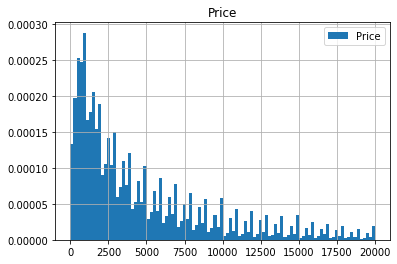

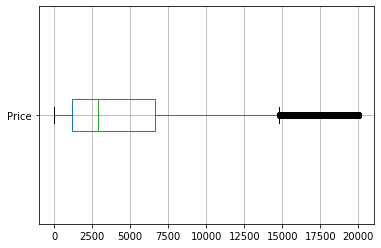

In [103]:
#посмотрим на гистограммы количественных признаков

#функция построения гистограммы и боксплот
def histag(rows, bins):
    for row in rows:
        plt.hist(
            auto[row],
            bins = bins,
            label = row,
            density=True
        )
        plt.grid(True)     
        plt.legend(loc='upper right')
        plt.title(row)
        plt.show()
        
        auto.boxplot(
            column = row,
            vert = False
        )
        plt.show()

#гистограмма для признака "Цена"
histag(['Price'], min(auto['Price'].nunique(), 100))

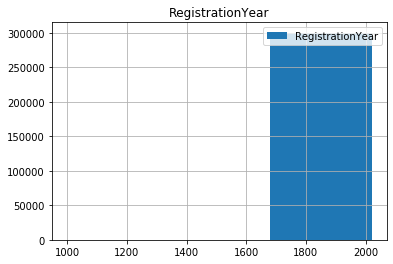

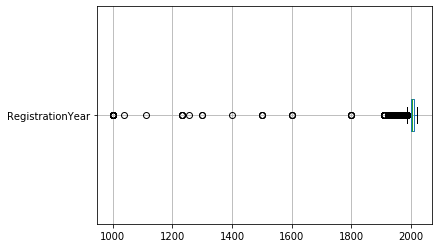

In [104]:
#посмотрим на гистограммы количественных признаков - Год регистрации
plt.hist(
    auto['RegistrationYear'],
    range = (1000, 2020),
    bins = 3,
    label = 'RegistrationYear'
    #density=True
)
plt.grid(True)     
plt.legend(loc='upper right')
plt.title('RegistrationYear')
plt.show()

auto.boxplot(
    column = 'RegistrationYear',
    vert = False
)
plt.show()


###  <font color='purple'> Первый автомобиль появился в 1885 году, поэтому необходимо убрать все объявления до этого года выпуска))</font>

In [105]:
#отфильтруем объявления, в которых год регистрации раньше  1885 года
auto = auto.query('RegistrationYear > 1885')
auto = auto.drop_duplicates().reset_index(drop=True)

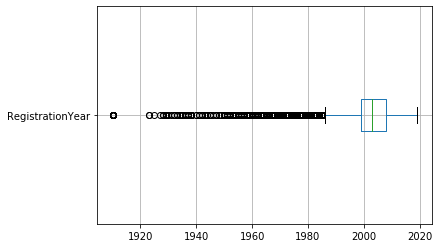

In [106]:
#построим боксплот после очистки данных столбца "Год регистрации"
auto.boxplot(
    column = 'RegistrationYear',
    vert = False
)
plt.show()

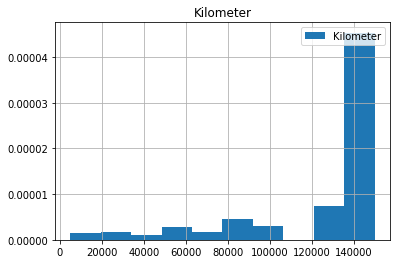

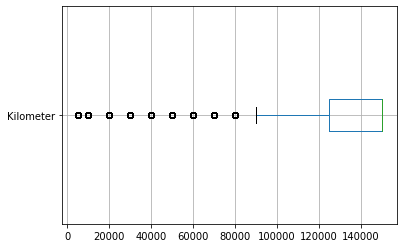

In [107]:
#посмотрим на гистограммы количественных признаков - Пробег, км
histag(['Kilometer'], min(auto['Kilometer'].nunique(), 10))

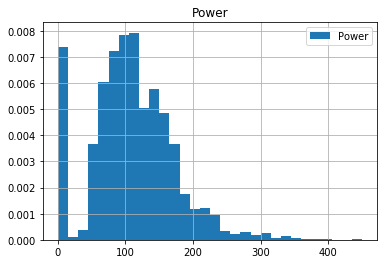

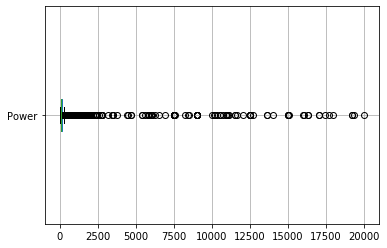

In [108]:
#посмотрим на гистограммы количественных признаков - Мощность двигателя
plt.hist(
    auto['Power'],
    range = (0, 450),
    bins = 30,
    label = 'Power',
    #xlim = ()
    density=True
)
plt.grid(True)     
plt.legend(loc='upper right')
plt.title('Power')
plt.show()

auto.boxplot(
    column = 'Power',
    vert = False
)
plt.show()

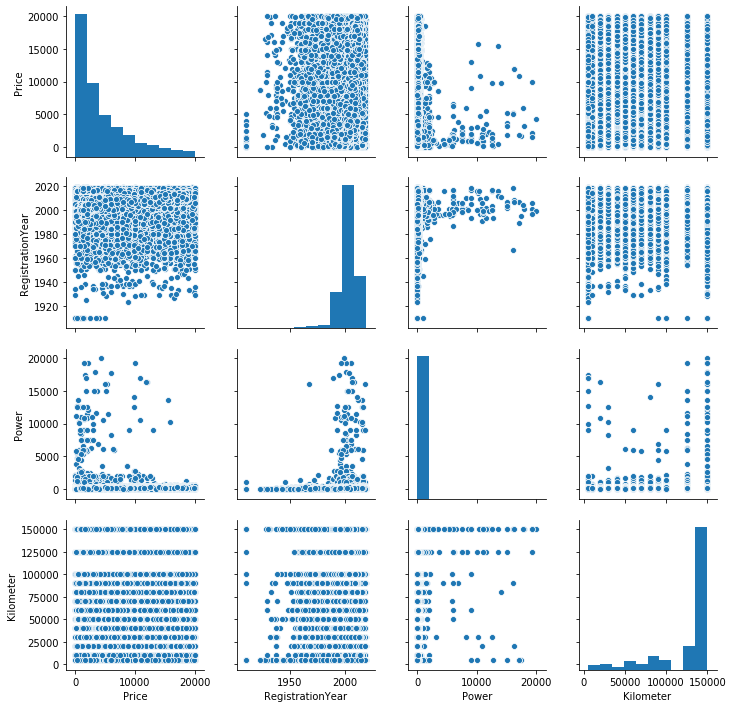

In [110]:
#посмотрим на корреляцию признаков
sns.pairplot(auto.loc[:, ['Price', 'RegistrationYear', 'Power', 'Kilometer']])

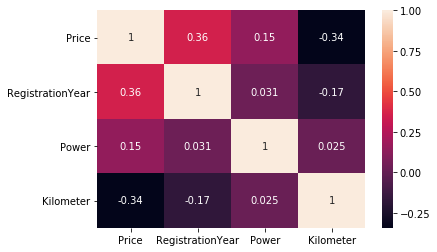

In [111]:
sns.heatmap(auto.corr(), annot = True)

# Вывод
Подготовили данные к построению модели, заполнили пропуски категориальных переменных значением unknown, удалили выбросы в признаках "цена" (удалили нули) и "год регистрации" (удалил значения выше 2020 года и ниже 1885). Удалили невлияющие на целевой признак параметры. Проверили оставшиеся количественные признаки на мультиколлинеарность, зависимости не найдено.

# 2. Обучение моделей <a name="Обучение-модели"></a>

## 1. Кодирование данных <a name="Кодирование-данных"></a>

### A. кодирование ОНЕ - <font color="purple">применяем для линейной регрессии</font>

In [112]:
#преобразуем категориальные признаки в численные с помощью метода OHE
auto_ohe = pd.get_dummies(auto,  drop_first=True)
auto_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300291 entries, 0 to 300290
Columns: 312 entries, Price to NotRepaired_yes
dtypes: int64(4), uint8(308)
memory usage: 97.4 MB


In [113]:
#Разобьем данные на целевой и нецелыве признаки
features_linreg = auto_ohe.drop(['Price'], axis=1)
target_linreg = auto_ohe.loc[:, ['Price']]

display(features_linreg.shape)
display(target_linreg.shape)

(300291, 311)

(300291, 1)

In [114]:
#Разобьем данные на обучающую (75%), тестовую (25%) выборки.
features_train_linreg, features_test_linreg, target_train_linreg, target_test_linreg = train_test_split (
    features_linreg, target_linreg, test_size=0.25, random_state=12345
)
display(features_train_linreg.shape, features_test_linreg.shape, target_train_linreg.shape, target_test_linreg.shape)

(225218, 311)

(75073, 311)

(225218, 1)

(75073, 1)

### <font color="purple"> Проведем масштабирование данных для линейной регрессии<font>

In [115]:
#проведем масштабирование
scaler_lin = StandardScaler()
scaler_train = scaler_lin.fit(features_train_linreg)
features_train_lin_stand = pd.DataFrame(scaler_train.transform(features_train_linreg), columns=features_train_linreg.columns)
features_test_lin_stand = pd.DataFrame(scaler_train.transform(features_test_linreg), columns=features_test_linreg.columns)

display(features_train_lin_stand.head(10))

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,0.233449,0.396948,-1.246036,3.971431,-0.221986,-0.100319,-0.584224,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
1,-0.295650,-0.058059,0.592805,-0.251798,-0.221986,-0.100319,1.711672,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
2,0.365723,-0.033331,0.592805,-0.251798,-0.221986,-0.100319,1.711672,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,1.964692,-0.09806,-0.500259,-0.342009
3,0.894822,-0.082788,-0.983344,-0.251798,-0.221986,-0.100319,1.711672,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
4,0.233449,0.021072,0.592805,-0.251798,-0.221986,-0.100319,-0.584224,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
5,-1.089298,0.401893,0.592805,-0.251798,-0.221986,-0.100319,-0.584224,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,1.998963,-0.342009
6,0.630273,-0.201485,-0.063924,3.971431,-0.221986,-0.100319,-0.584224,-0.532088,-0.192071,-0.343319,...,7.873884,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
7,0.630273,-0.127299,-2.034110,-0.251798,-0.221986,-0.100319,1.711672,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
8,-0.560200,-0.181702,0.592805,-0.251798,-0.221986,-0.100319,-0.584224,1.879387,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009
9,0.497998,0.189227,0.592805,-0.251798,-0.221986,-0.100319,1.711672,-0.532088,-0.192071,-0.343319,...,-0.127002,-0.09468,-0.047594,-0.084454,-0.117886,-0.038884,-0.508986,-0.09806,-0.500259,-0.342009


### Б. кодирование Ordinal Encoding

### <font color='purple'> Закодируем только категориальные переменный</font>

In [117]:
#составим список категориальных переменных
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [118]:
#преобразуем категориаьные признаки в численные с помощью метода Ordinal Encoding
encoder = OrdinalEncoder()
auto_ordenc = pd.DataFrame(encoder
                           .fit_transform(
                               auto.loc[:,['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]),
                           columns=category)
auto_ordenc

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,7.0,1.0,116.0,6.0,38.0,1.0
1,2.0,1.0,228.0,2.0,1.0,2.0
2,6.0,0.0,117.0,2.0,14.0,1.0
3,5.0,1.0,116.0,6.0,38.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0
...,...,...,...,...,...,...
300286,4.0,1.0,140.0,6.0,30.0,2.0
300287,7.0,2.0,228.0,7.0,33.0,1.0
300288,1.0,0.0,106.0,6.0,32.0,0.0
300289,0.0,1.0,224.0,2.0,38.0,0.0


### <font color='purple'>Обновим исходную таблицу закодированными данными</font>

In [119]:
#выделяем количественные признаки
counts = auto.loc[:,['Price', 'RegistrationYear', 'Power', 'Kilometer']]
display(counts.tail(10))

,Price,RegistrationYear,Power,Kilometer
300281,5000,2003,260,150000
300282,999,2000,95,150000
300283,1690,2004,55,150000
300284,3999,2005,3,150000
300285,5250,2016,150,150000
300286,3200,2004,225,150000
300287,2200,2005,0,20000
300288,1199,2000,101,125000
300289,9200,1996,102,150000
300290,3400,2002,100,150000


In [120]:
display(auto_ordenc.tail(10))

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
300281,4.0,0.0,95.0,2.0,20.0,2.0
300282,1.0,1.0,149.0,6.0,27.0,1.0
300283,8.0,1.0,101.0,6.0,31.0,1.0
300284,8.0,1.0,11.0,2.0,2.0,0.0
300285,7.0,0.0,4.0,7.0,0.0,0.0
300286,4.0,1.0,140.0,6.0,30.0,2.0
300287,7.0,2.0,228.0,7.0,33.0,1.0
300288,1.0,0.0,106.0,6.0,32.0,0.0
300289,0.0,1.0,224.0,2.0,38.0,0.0
300290,8.0,1.0,116.0,2.0,38.0,1.0


In [121]:
#объединяем таблицы с количественными и качественными признаками
auto_cat = pd.concat([counts, auto_ordenc], axis=1)
auto_cat.tail(10)

,Price,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
300281,5000,2003,260,150000,4.0,0.0,95.0,2.0,20.0,2.0
300282,999,2000,95,150000,1.0,1.0,149.0,6.0,27.0,1.0
300283,1690,2004,55,150000,8.0,1.0,101.0,6.0,31.0,1.0
300284,3999,2005,3,150000,8.0,1.0,11.0,2.0,2.0,0.0
300285,5250,2016,150,150000,7.0,0.0,4.0,7.0,0.0,0.0
300286,3200,2004,225,150000,4.0,1.0,140.0,6.0,30.0,2.0
300287,2200,2005,0,20000,7.0,2.0,228.0,7.0,33.0,1.0
300288,1199,2000,101,125000,1.0,0.0,106.0,6.0,32.0,0.0
300289,9200,1996,102,150000,0.0,1.0,224.0,2.0,38.0,0.0
300290,3400,2002,100,150000,8.0,1.0,116.0,2.0,38.0,1.0


In [122]:
#Разобьем данные на целевой и нецелыве признаки
features = auto_cat.drop(['Price'], axis=1)
target = auto_cat.loc[:, ['Price']]

display(features.info())
display(target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300291 entries, 0 to 300290
Data columns (total 9 columns):
RegistrationYear    300291 non-null int64
Power               300291 non-null int64
Kilometer           300291 non-null int64
VehicleType         300291 non-null float64
Gearbox             300291 non-null float64
Model               300291 non-null float64
FuelType            300291 non-null float64
Brand               300291 non-null float64
NotRepaired         300291 non-null float64
dtypes: float64(6), int64(3)
memory usage: 20.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300291 entries, 0 to 300290
Data columns (total 1 columns):
Price    300291 non-null int64
dtypes: int64(1)
memory usage: 2.3 MB


None

In [123]:
#Разобьем данные на обучающую (75%), тестовую (25%) выборки.
features_train, features_test, target_train, target_test = train_test_split (
    features, target, test_size=0.25, random_state=12345
)
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(225218, 9)

(75073, 9)

(225218, 1)

(75073, 1)

### <font color='purple'>Проведем обучение scaler только на обучающей выборке</font>

In [124]:
#проведем стандартизацию числовых признаков

scaler = StandardScaler()
scaler_train = scaler.fit(features_train)
features_train_stand = scaler_train.transform(features_train)
features_test_stand = scaler_train.transform(features_test)

display(features_train_stand)

array([[ 0.23344852,  0.39694771, -1.24603573, ...,  0.5653746 ,
        -1.41867055, -0.60974662],
       [-0.29565025, -0.05805923,  0.59280492, ...,  0.5653746 ,
        -0.8124737 , -0.60974662],
       [ 0.36572321, -0.0333306 ,  0.59280492, ..., -1.55809959,
         1.30921528, -0.60974662],
       ...,
       [ 0.36572321, -0.23610543, -0.72065269, ...,  0.5653746 ,
         1.30921528, -0.60974662],
       [ 0.36572321,  0.06558396, -0.72065269, ...,  0.5653746 ,
         0.24837079, -0.60974662],
       [ 1.82074482,  0.02107241,  0.59280492, ...,  0.5653746 ,
         1.30921528,  0.87886504]])

In [125]:
#функция для вычеслени RSME
def rmse(answer, prediction):
    rmse = mean_squared_error(answer, prediction) ** 0.5
    return rmse

In [126]:
#создадим метрику для RSME
rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

### 2. Модель линейной регрессии <a name="Модель-линейной-регрессии"></a>

In [146]:
%%time
#обучаем модель линейной регрессий и проводим кросс-валидацию
cross_val_linreg = cross_val_score(LinearRegression(),
                                  features_train_lin_stand, target_train_linreg,
                                  scoring = rmse_scorer,
                                  cv=5)

CPU times: user 1min 15s, sys: 24.7 s, total: 1min 39s
Wall time: 1min 39s


In [147]:
#рассчитываем качество модели линейно регрессии метрикой RMSE
rmse_cross_lin = cross_val_linreg.mean() * (-1)
print('RSME:', round(rmse_cross_lin, 2))

RSME: 2907.61


### 3. Модель градиентного бустинга Catboost <a name="Модель-градиентного-бустинга-Catboost"></a>

### А. Проведем подбор параметров и кросс-валидацию с помощью GridSearchCV

In [127]:
model = CatBoostRegressor()
parameters = {'depth'         : [5, 6],
              'learning_rate' : [0.5, 0.75],
              'iterations'    : [700, 850]
             }
grid = GridSearchCV(estimator=model,
                    param_grid = parameters,
                    cv = 5,
                    n_jobs=-1,
                    scoring='neg_mean_squared_error')

"model = CatBoostRegressor()\nparameters = {'depth'         : [5, 6],\n              'learning_rate' : [0.5, 0.75],\n              'iterations'    : [700, 850]\n             }\ngrid = GridSearchCV(estimator=model,\n                    param_grid = parameters,\n                    cv = 5,\n                    n_jobs=-1,\n                    scoring='neg_mean_squared_error')"

### результат обучения

0:	learn: 708.1957265	total: 412ms	remaining: 4m 47s
50:	learn: 382.0453352	total: 14.3s	remaining: 3m 1s
100:	learn: 365.8712904	total: 29.5s	remaining: 2m 54s
150:	learn: 357.5709979	total: 45s	remaining: 2m 43s
200:	learn: 351.2777436	total: 1m	remaining: 2m 30s
250:	learn: 346.8551969	total: 1m 8s	remaining: 2m 2s
300:	learn: 343.1991753	total: 1m 14s	remaining: 1m 38s
350:	learn: 339.8619064	total: 1m 20s	remaining: 1m 19s
400:	learn: 336.8430122	total: 1m 26s	remaining: 1m 4s
450:	learn: 334.1870573	total: 1m 32s	remaining: 50.8s
500:	learn: 331.9978905	total: 1m 38s	remaining: 39.1s
550:	learn: 329.9783243	total: 1m 44s	remaining: 28.3s
600:	learn: 328.2547356	total: 1m 50s	remaining: 18.2s
650:	learn: 326.4908153	total: 1m 56s	remaining: 8.75s
699:	learn: 324.8146338	total: 2m 1s	remaining: 0us
0:	learn: 701.5417147	total: 61.4ms	remaining: 42.9s
50:	learn: 380.1682466	total: 5.84s	remaining: 1m 14s
100:	learn: 364.5338363	total: 11.5s	remaining: 1m 8s
150:	learn: 356.7098143	total: 16.8s	remaining: 1m 1s
200:	learn: 350.7269079	total: 22.1s	remaining: 55s
250:	learn: 345.7478529	total: 27.7s	remaining: 49.5s
300:	learn: 342.1938616	total: 33.3s	remaining: 44.2s
350:	learn: 339.2980482	total: 38.8s	remaining: 38.6s
400:	learn: 336.0943920	total: 44.5s	remaining: 33.2s
450:	learn: 333.5894710	total: 50.3s	remaining: 27.7s
500:	learn: 331.1478900	total: 55.8s	remaining: 22.2s
550:	learn: 328.9966053	total: 1m 1s	remaining: 16.6s
600:	learn: 327.1501383	total: 1m 6s	remaining: 11s
650:	learn: 325.4801690	total: 1m 12s	remaining: 5.44s
699:	learn: 323.8672933	total: 1m 17s	remaining: 0us
0:	learn: 706.8228552	total: 23.3ms	remaining: 16.3s
50:	learn: 379.9854308	total: 5.51s	remaining: 1m 10s
100:	learn: 364.5332040	total: 11.4s	remaining: 1m 7s
150:	learn: 356.2146434	total: 17.4s	remaining: 1m 3s
200:	learn: 350.3596698	total: 23.5s	remaining: 58.4s
250:	learn: 345.8379594	total: 29.5s	remaining: 52.8s
300:	learn: 342.1115151	total: 35.6s	remaining: 47.1s
350:	learn: 338.9483290	total: 41.6s	remaining: 41.4s
400:	learn: 336.0202369	total: 48.7s	remaining: 36.3s
450:	learn: 333.6155202	total: 55.7s	remaining: 30.7s
500:	learn: 331.1922733	total: 1m 3s	remaining: 25.1s
550:	learn: 329.1753607	total: 1m 10s	remaining: 19.1s
600:	learn: 327.2367028	total: 1m 16s	remaining: 12.6s
650:	learn: 325.5353547	total: 1m 22s	remaining: 6.21s
699:	learn: 323.8603429	total: 1m 28s	remaining: 0us
0:	learn: 699.9993143	total: 91.9ms	remaining: 1m 4s
50:	learn: 379.1996488	total: 6.17s	remaining: 1m 18s
100:	learn: 364.2591573	total: 12.2s	remaining: 1m 12s
150:	learn: 355.5989644	total: 18.4s	remaining: 1m 6s
200:	learn: 350.0060882	total: 24.5s	remaining: 1m
250:	learn: 345.6144519	total: 39s	remaining: 1m 9s
300:	learn: 342.0284992	total: 54s	remaining: 1m 11s
350:	learn: 338.8893241	total: 1m 8s	remaining: 1m 7s
400:	learn: 336.2265442	total: 1m 22s	remaining: 1m 1s
450:	learn: 333.7683844	total: 1m 36s	remaining: 53.4s
500:	learn: 331.7445332	total: 1m 51s	remaining: 44.5s
550:	learn: 329.8374530	total: 2m 6s	remaining: 34.2s
600:	learn: 327.7267413	total: 2m 21s	remaining: 23.3s
650:	learn: 325.9209081	total: 2m 35s	remaining: 11.7s
699:	learn: 324.2510313	total: 2m 49s	remaining: 0us
0:	learn: 708.1415500	total: 302ms	remaining: 3m 30s
50:	learn: 382.1638880	total: 14.4s	remaining: 3m 2s
100:	learn: 365.0341816	total: 29.6s	remaining: 2m 55s
150:	learn: 356.2759047	total: 44.9s	remaining: 2m 43s
200:	learn: 350.5405786	total: 1m	remaining: 2m 30s
250:	learn: 346.1418104	total: 1m 15s	remaining: 2m 14s
300:	learn: 342.8559272	total: 1m 28s	remaining: 1m 57s
350:	learn: 339.7166120	total: 1m 42s	remaining: 1m 42s
400:	learn: 337.1192993	total: 1m 56s	remaining: 1m 26s
450:	learn: 334.6203023	total: 2m 10s	remaining: 1m 12s
500:	learn: 332.2764843	total: 2m 26s	remaining: 58.1s
550:	learn: 330.2500289	total: 2m 40s	remaining: 43.5s
600:	learn: 328.4443857	total: 2m 50s	remaining: 28.1s
650:	learn: 326.7803806	total: 2m 56s	remaining: 13.3s
699:	learn: 325.2415892	total: 3m 2s	remaining: 0us
0:	learn: 631.2860339	total: 71ms	remaining: 49.7s
50:	learn: 376.5177834	total: 6.85s	remaining: 1m 27s
100:	learn: 360.7688209	total: 13.1s	remaining: 1m 17s
150:	learn: 352.4498554	total: 19.4s	remaining: 1m 10s
200:	learn: 346.4582867	total: 26.6s	remaining: 1m 5s
250:	learn: 341.6061404	total: 34.2s	remaining: 1m 1s
300:	learn: 337.9112281	total: 41.6s	remaining: 55.2s
350:	learn: 334.6710760	total: 48.5s	remaining: 48.2s
400:	learn: 331.5495716	total: 58.7s	remaining: 43.7s
450:	learn: 328.6848736	total: 1m 12s	remaining: 40.1s
500:	learn: 326.2486836	total: 1m 27s	remaining: 34.6s
550:	learn: 324.2714266	total: 1m 41s	remaining: 27.6s
600:	learn: 322.3684096	total: 1m 57s	remaining: 19.3s
650:	learn: 320.6232495	total: 2m 12s	remaining: 9.97s
699:	learn: 319.0590577	total: 2m 26s	remaining: 0us
0:	learn: 622.0778064	total: 247ms	remaining: 2m 52s
50:	learn: 373.5383682	total: 15.3s	remaining: 3m 14s
100:	learn: 358.9679627	total: 30.7s	remaining: 3m 2s
150:	learn: 350.8948923	total: 44.2s	remaining: 2m 40s
200:	learn: 345.1004692	total: 57.7s	remaining: 2m 23s
250:	learn: 340.3046312	total: 1m 11s	remaining: 2m 7s
300:	learn: 336.4629706	total: 1m 25s	remaining: 1m 53s
350:	learn: 333.2769496	total: 1m 38s	remaining: 1m 38s
400:	learn: 330.4524090	total: 1m 52s	remaining: 1m 23s
450:	learn: 327.8361422	total: 2m 6s	remaining: 1m 9s
500:	learn: 325.4592886	total: 2m 20s	remaining: 55.8s
550:	learn: 323.3657392	total: 2m 33s	remaining: 41.5s
600:	learn: 321.2318001	total: 2m 47s	remaining: 27.6s
650:	learn: 319.3427442	total: 3m	remaining: 13.6s
699:	learn: 317.5037599	total: 3m 15s	remaining: 0us
0:	learn: 629.3324210	total: 457ms	remaining: 5m 19s
50:	learn: 375.1675193	total: 20.8s	remaining: 4m 24s
100:	learn: 359.2414070	total: 41.8s	remaining: 4m 8s
150:	learn: 350.9154147	total: 1m 1s	remaining: 3m 44s
200:	learn: 345.0782329	total: 1m 22s	remaining: 3m 24s
250:	learn: 340.3879659	total: 1m 44s	remaining: 3m 6s
300:	learn: 336.2926745	total: 2m 5s	remaining: 2m 45s
350:	learn: 333.5027283	total: 2m 25s	remaining: 2m 24s
400:	learn: 330.8482862	total: 2m 41s	remaining: 2m
450:	learn: 328.3496150	total: 2m 55s	remaining: 1m 37s
500:	learn: 326.0414383	total: 3m 11s	remaining: 1m 15s
550:	learn: 323.9579223	total: 3m 25s	remaining: 55.7s
600:	learn: 321.8157774	total: 3m 35s	remaining: 35.5s
650:	learn: 320.0754502	total: 3m 41s	remaining: 16.7s
699:	learn: 318.2946912	total: 3m 47s	remaining: 0us
0:	learn: 620.1464683	total: 33.2ms	remaining: 23.2s
50:	learn: 376.2367296	total: 6.01s	remaining: 1m 16s
100:	learn: 359.4564760	total: 12.1s	remaining: 1m 11s
150:	learn: 351.3898572	total: 18.1s	remaining: 1m 5s
200:	learn: 345.2093655	total: 24.1s	remaining: 59.9s
250:	learn: 340.7351068	total: 30.2s	remaining: 54s
300:	learn: 336.9135300	total: 36.5s	remaining: 48.4s
350:	learn: 333.3876234	total: 42.6s	remaining: 42.4s
400:	learn: 330.6323441	total: 48.8s	remaining: 36.4s
450:	learn: 327.9596812	total: 54.9s	remaining: 30.3s
500:	learn: 325.8675115	total: 1m 1s	remaining: 24.2s
550:	learn: 323.9574713	total: 1m 7s	remaining: 18.1s
600:	learn: 322.2717574	total: 1m 13s	remaining: 12.1s
650:	learn: 320.2580612	total: 1m 19s	remaining: 5.97s
699:	learn: 318.8427070	total: 1m 25s	remaining: 0us
0:	learn: 631.1244453	total: 110ms	remaining: 1m 17s
50:	learn: 376.1347834	total: 6.66s	remaining: 1m 24s
100:	learn: 360.0436708	total: 12.9s	remaining: 1m 16s
150:	learn: 351.8938884	total: 19.2s	remaining: 1m 9s
200:	learn: 345.8008812	total: 25.6s	remaining: 1m 3s
250:	learn: 340.5750504	total: 31.9s	remaining: 57.1s
300:	learn: 336.4251354	total: 38.2s	remaining: 50.6s
350:	learn: 333.3891384	total: 44.4s	remaining: 44.1s
400:	learn: 330.6082104	total: 50.6s	remaining: 37.7s
450:	learn: 328.2626017	total: 57s	remaining: 31.5s
500:	learn: 326.0125382	total: 1m 3s	remaining: 25.2s
550:	learn: 323.6730179	total: 1m 9s	remaining: 18.9s
600:	learn: 321.6589712	total: 1m 16s	remaining: 12.5s
650:	learn: 319.8141610	total: 1m 22s	remaining: 6.19s
699:	learn: 318.2185832	total: 1m 28s	remaining: 0us
0:	learn: 708.1957265	total: 46.5ms	remaining: 39.4s
50:	learn: 382.0453352	total: 6.32s	remaining: 1m 39s
100:	learn: 365.8712904	total: 12.6s	remaining: 1m 33s
150:	learn: 357.5709979	total: 18.9s	remaining: 1m 27s
200:	learn: 351.2777436	total: 25s	remaining: 1m 20s
250:	learn: 346.8551969	total: 31.8s	remaining: 1m 15s
300:	learn: 343.1991753	total: 38.1s	remaining: 1m 9s
350:	learn: 339.8619064	total: 44.3s	remaining: 1m 3s
400:	learn: 336.8430122	total: 51s	remaining: 57.1s
450:	learn: 334.1870573	total: 56.9s	remaining: 50.4s
500:	learn: 331.9978905	total: 1m 3s	remaining: 44s
550:	learn: 329.9783243	total: 1m 9s	remaining: 37.6s
600:	learn: 328.2547356	total: 1m 15s	remaining: 31.3s
650:	learn: 326.4908153	total: 1m 21s	remaining: 24.9s
700:	learn: 324.7430235	total: 1m 27s	remaining: 18.7s
750:	learn: 323.2141255	total: 1m 33s	remaining: 12.4s
800:	learn: 321.8846588	total: 1m 40s	remaining: 6.13s
849:	learn: 320.5401716	total: 1m 46s	remaining: 0us
0:	learn: 701.5417147	total: 84ms	remaining: 1m 11s
50:	learn: 380.1682466	total: 6.25s	remaining: 1m 38s
100:	learn: 364.5338363	total: 12.5s	remaining: 1m 32s
150:	learn: 356.7098143	total: 18.7s	remaining: 1m 26s
200:	learn: 350.7269079	total: 24.9s	remaining: 1m 20s
250:	learn: 345.7478529	total: 31s	remaining: 1m 14s
300:	learn: 342.1938616	total: 37.4s	remaining: 1m 8s
350:	learn: 339.2980482	total: 43.5s	remaining: 1m 1s
400:	learn: 336.0943920	total: 49.8s	remaining: 55.8s
450:	learn: 333.5894710	total: 56.1s	remaining: 49.6s
500:	learn: 331.1478900	total: 1m 2s	remaining: 43.5s
550:	learn: 328.9966053	total: 1m 8s	remaining: 37.3s
600:	learn: 327.1501383	total: 1m 14s	remaining: 31s
650:	learn: 325.4801690	total: 1m 21s	remaining: 24.8s
700:	learn: 323.8557214	total: 1m 27s	remaining: 18.6s
750:	learn: 322.3892022	total: 1m 33s	remaining: 12.3s
800:	learn: 321.0575443	total: 1m 39s	remaining: 6.09s
849:	learn: 319.5824615	total: 1m 45s	remaining: 0us
0:	learn: 706.8228552	total: 114ms	remaining: 1m 36s
50:	learn: 379.9854308	total: 6.48s	remaining: 1m 41s
100:	learn: 364.5332040	total: 12.8s	remaining: 1m 35s
150:	learn: 356.2146434	total: 19s	remaining: 1m 27s
200:	learn: 350.3596698	total: 25.1s	remaining: 1m 20s
250:	learn: 345.8379594	total: 30.8s	remaining: 1m 13s
300:	learn: 342.1115151	total: 36.8s	remaining: 1m 7s
350:	learn: 338.9483290	total: 42.7s	remaining: 1m
400:	learn: 336.0202369	total: 48.7s	remaining: 54.5s
450:	learn: 333.6155202	total: 54.5s	remaining: 48.2s
500:	learn: 331.1922733	total: 1m	remaining: 42.2s
550:	learn: 329.1753607	total: 1m 6s	remaining: 36.2s
600:	learn: 327.2367028	total: 1m 12s	remaining: 30.1s
650:	learn: 325.5353547	total: 1m 18s	remaining: 24s
700:	learn: 323.8450658	total: 1m 24s	remaining: 17.9s
750:	learn: 322.4758198	total: 1m 30s	remaining: 11.9s
800:	learn: 321.1209878	total: 1m 36s	remaining: 5.88s
849:	learn: 319.7027676	total: 1m 42s	remaining: 0us
0:	learn: 699.9993143	total: 44.1ms	remaining: 37.4s
50:	learn: 379.1996488	total: 5.52s	remaining: 1m 26s
100:	learn: 364.2591573	total: 11s	remaining: 1m 21s
150:	learn: 355.5989644	total: 16.7s	remaining: 1m 17s
200:	learn: 350.0060882	total: 22.3s	remaining: 1m 12s
250:	learn: 345.6144519	total: 28.3s	remaining: 1m 7s
300:	learn: 342.0284992	total: 34.3s	remaining: 1m 2s
350:	learn: 338.8893241	total: 40.3s	remaining: 57.2s
400:	learn: 336.2265442	total: 46.3s	remaining: 51.9s
450:	learn: 333.7683844	total: 52.1s	remaining: 46.1s
500:	learn: 331.7445332	total: 58.1s	remaining: 40.5s
550:	learn: 329.8374530	total: 1m 4s	remaining: 34.8s
600:	learn: 327.7267413	total: 1m 10s	remaining: 29s
650:	learn: 325.9209081	total: 1m 16s	remaining: 23.3s
700:	learn: 324.2240529	total: 1m 22s	remaining: 17.4s
750:	learn: 322.6392183	total: 1m 28s	remaining: 11.6s
800:	learn: 321.3158808	total: 1m 34s	remaining: 5.75s
849:	learn: 319.9354589	total: 1m 39s	remaining: 0us
0:	learn: 708.1415500	total: 21.4ms	remaining: 18.2s
50:	learn: 382.1638880	total: 5.91s	remaining: 1m 32s
100:	learn: 365.0341816	total: 11.9s	remaining: 1m 28s
150:	learn: 356.2759047	total: 18s	remaining: 1m 23s
200:	learn: 350.5405786	total: 23.9s	remaining: 1m 17s
250:	learn: 346.1418104	total: 30.1s	remaining: 1m 11s
300:	learn: 342.8559272	total: 36.1s	remaining: 1m 5s
350:	learn: 339.7166120	total: 42.1s	remaining: 59.9s
400:	learn: 337.1192993	total: 48s	remaining: 53.7s
450:	learn: 334.6203023	total: 53.6s	remaining: 47.4s
500:	learn: 332.2764843	total: 59.6s	remaining: 41.5s
550:	learn: 330.2500289	total: 1m 5s	remaining: 35.5s
600:	learn: 328.4443857	total: 1m 11s	remaining: 29.6s
650:	learn: 326.7803806	total: 1m 17s	remaining: 23.6s
700:	learn: 325.2214386	total: 1m 23s	remaining: 17.7s
750:	learn: 323.7670797	total: 1m 29s	remaining: 11.7s
800:	learn: 322.2386959	total: 1m 34s	remaining: 5.8s
849:	learn: 320.9454734	total: 1m 40s	remaining: 0us
0:	learn: 631.2860339	total: 97.3ms	remaining: 1m 22s
50:	learn: 376.5177834	total: 6.07s	remaining: 1m 35s
100:	learn: 360.7688209	total: 12s	remaining: 1m 28s
150:	learn: 352.4498554	total: 17.8s	remaining: 1m 22s
200:	learn: 346.4582867	total: 23.9s	remaining: 1m 17s
250:	learn: 341.6061404	total: 29.8s	remaining: 1m 11s
300:	learn: 337.9112281	total: 35.7s	remaining: 1m 5s
350:	learn: 334.6710760	total: 41.7s	remaining: 59.3s
400:	learn: 331.5495716	total: 48.1s	remaining: 53.8s
450:	learn: 328.6848736	total: 54.2s	remaining: 47.9s
500:	learn: 326.2486836	total: 1m	remaining: 42s
550:	learn: 324.2714266	total: 1m 6s	remaining: 35.9s
600:	learn: 322.3684096	total: 1m 12s	remaining: 29.9s
650:	learn: 320.6232495	total: 1m 18s	remaining: 23.9s
700:	learn: 319.0490183	total: 1m 23s	remaining: 17.8s
750:	learn: 317.2419846	total: 1m 29s	remaining: 11.9s
800:	learn: 315.8250753	total: 1m 35s	remaining: 5.87s
849:	learn: 314.6371572	total: 1m 41s	remaining: 0us
0:	learn: 622.0778064	total: 102ms	remaining: 1m 26s
50:	learn: 373.5383682	total: 6.28s	remaining: 1m 38s
100:	learn: 358.9679627	total: 12.5s	remaining: 1m 33s
150:	learn: 350.8948923	total: 18.8s	remaining: 1m 27s
200:	learn: 345.1004692	total: 25.1s	remaining: 1m 21s
250:	learn: 340.3046312	total: 31.4s	remaining: 1m 14s
300:	learn: 336.4629706	total: 37.6s	remaining: 1m 8s
350:	learn: 333.2769496	total: 43.8s	remaining: 1m 2s
400:	learn: 330.4524090	total: 50.1s	remaining: 56.1s
450:	learn: 327.8361422	total: 56.3s	remaining: 49.8s
500:	learn: 325.4592886	total: 1m 2s	remaining: 43.7s
550:	learn: 323.3657392	total: 1m 8s	remaining: 37.4s
600:	learn: 321.2318001	total: 1m 14s	remaining: 31s
650:	learn: 319.3427442	total: 1m 21s	remaining: 24.8s
700:	learn: 317.4692423	total: 1m 27s	remaining: 18.6s
750:	learn: 315.9279170	total: 1m 33s	remaining: 12.3s
800:	learn: 314.5162610	total: 1m 39s	remaining: 6.08s
849:	learn: 313.0938203	total: 1m 45s	remaining: 0us
0:	learn: 629.3324210	total: 66.6ms	remaining: 56.5s
50:	learn: 375.1675193	total: 6.33s	remaining: 1m 39s
100:	learn: 359.2414070	total: 12.6s	remaining: 1m 33s
150:	learn: 350.9154147	total: 19s	remaining: 1m 27s
200:	learn: 345.0782329	total: 25s	remaining: 1m 20s
250:	learn: 340.3879659	total: 31.5s	remaining: 1m 15s
300:	learn: 336.2926745	total: 37.9s	remaining: 1m 9s
350:	learn: 333.5027283	total: 43.9s	remaining: 1m 2s
400:	learn: 330.8482862	total: 50s	remaining: 56s
450:	learn: 328.3496150	total: 56.1s	remaining: 49.7s
500:	learn: 326.0414383	total: 1m 2s	remaining: 43.4s
550:	learn: 323.9579223	total: 1m 8s	remaining: 37.2s
600:	learn: 321.8157774	total: 1m 14s	remaining: 30.9s
650:	learn: 320.0754502	total: 1m 20s	remaining: 24.6s
700:	learn: 318.2875543	total: 1m 26s	remaining: 18.4s
750:	learn: 316.7150360	total: 1m 32s	remaining: 12.1s
800:	learn: 315.3598083	total: 1m 37s	remaining: 5.99s
849:	learn: 313.9909310	total: 1m 43s	remaining: 0us
0:	learn: 620.1464683	total: 66ms	remaining: 56s
50:	learn: 376.2367296	total: 5.92s	remaining: 1m 32s
100:	learn: 359.4564760	total: 11.9s	remaining: 1m 28s
150:	learn: 351.3898572	total: 17.6s	remaining: 1m 21s
200:	learn: 345.2093655	total: 23.5s	remaining: 1m 15s
250:	learn: 340.7351068	total: 29.4s	remaining: 1m 10s
300:	learn: 336.9135300	total: 35.4s	remaining: 1m 4s
350:	learn: 333.3876234	total: 41.3s	remaining: 58.8s
400:	learn: 330.6323441	total: 47.1s	remaining: 52.7s
450:	learn: 327.9596812	total: 53s	remaining: 46.9s
500:	learn: 325.8675115	total: 58.6s	remaining: 40.9s
550:	learn: 323.9574713	total: 1m 4s	remaining: 34.9s
600:	learn: 322.2717574	total: 1m 10s	remaining: 29.1s
650:	learn: 320.2580612	total: 1m 16s	remaining: 23.3s
700:	learn: 318.8200589	total: 1m 22s	remaining: 17.5s
750:	learn: 316.9965772	total: 1m 28s	remaining: 11.6s
800:	learn: 315.5714910	total: 1m 34s	remaining: 5.76s
849:	learn: 314.0705795	total: 1m 40s	remaining: 0us
0:	learn: 631.1244453	total: 45.4ms	remaining: 38.5s
50:	learn: 376.1347834	total: 6.02s	remaining: 1m 34s
100:	learn: 360.0436708	total: 11.8s	remaining: 1m 27s
150:	learn: 351.8938884	total: 17.6s	remaining: 1m 21s
200:	learn: 345.8008812	total: 23.5s	remaining: 1m 15s
250:	learn: 340.5750504	total: 29.5s	remaining: 1m 10s
300:	learn: 336.4251354	total: 35.4s	remaining: 1m 4s
350:	learn: 333.3891384	total: 41.5s	remaining: 59s
400:	learn: 330.6082104	total: 47.6s	remaining: 53.3s
450:	learn: 328.2626017	total: 53.5s	remaining: 47.4s
500:	learn: 326.0125382	total: 59.4s	remaining: 41.4s
550:	learn: 323.6730179	total: 1m 5s	remaining: 35.4s
600:	learn: 321.6589712	total: 1m 10s	remaining: 29.4s
650:	learn: 319.8141610	total: 1m 16s	remaining: 23.5s
700:	learn: 318.2085387	total: 1m 22s	remaining: 17.6s
750:	learn: 316.5204947	total: 1m 28s	remaining: 11.7s
800:	learn: 315.0757634	total: 1m 34s	remaining: 5.77s
849:	learn: 313.7084422	total: 1m 40s	remaining: 0us
0:	learn: 687.9548716	total: 87.5ms	remaining: 1m 1s
50:	learn: 372.7026481	total: 7.15s	remaining: 1m 31s
100:	learn: 356.7352428	total: 14.2s	remaining: 1m 24s
150:	learn: 348.3587077	total: 21.1s	remaining: 1m 16s
200:	learn: 341.9311574	total: 28.2s	remaining: 1m 9s
250:	learn: 336.7379891	total: 35.1s	remaining: 1m 2s
300:	learn: 332.5606886	total: 42.1s	remaining: 55.8s
350:	learn: 329.1979862	total: 49.1s	remaining: 48.8s
400:	learn: 326.1611102	total: 56.1s	remaining: 41.8s
450:	learn: 323.3812484	total: 1m 3s	remaining: 34.8s
500:	learn: 320.8267394	total: 1m 10s	remaining: 27.9s
550:	learn: 318.3163460	total: 1m 17s	remaining: 20.9s
600:	learn: 316.2208944	total: 1m 24s	remaining: 13.8s
650:	learn: 314.3596428	total: 1m 30s	remaining: 6.83s
699:	learn: 312.6178773	total: 1m 37s	remaining: 0us
0:	learn: 683.8708480	total: 76.3ms	remaining: 53.3s
50:	learn: 372.1367533	total: 7.24s	remaining: 1m 32s
100:	learn: 356.5796199	total: 14.6s	remaining: 1m 26s
150:	learn: 347.4752550	total: 21.6s	remaining: 1m 18s
200:	learn: 341.1379804	total: 28.6s	remaining: 1m 11s
250:	learn: 336.3327996	total: 35.5s	remaining: 1m 3s
300:	learn: 332.0107987	total: 42.4s	remaining: 56.2s
350:	learn: 328.5042776	total: 49.2s	remaining: 49s
400:	learn: 325.3639129	total: 56.1s	remaining: 41.8s
450:	learn: 322.8350372	total: 1m 2s	remaining: 34.6s
500:	learn: 320.4359016	total: 1m 9s	remaining: 27.5s
550:	learn: 318.0897878	total: 1m 16s	remaining: 20.6s
600:	learn: 315.7208219	total: 1m 22s	remaining: 13.7s
650:	learn: 313.6014077	total: 1m 29s	remaining: 6.74s
699:	learn: 311.8180196	total: 1m 36s	remaining: 0us
0:	learn: 685.9155383	total: 48ms	remaining: 33.5s
50:	learn: 372.8380115	total: 6.72s	remaining: 1m 25s
100:	learn: 356.6013583	total: 13.5s	remaining: 1m 20s
150:	learn: 347.3025482	total: 20.3s	remaining: 1m 13s
200:	learn: 340.7850757	total: 26.9s	remaining: 1m 6s
250:	learn: 336.1533241	total: 33.2s	remaining: 59.4s
300:	learn: 331.9518533	total: 39.8s	remaining: 52.7s
350:	learn: 328.5163632	total: 46.4s	remaining: 46.1s
400:	learn: 325.4719032	total: 52.9s	remaining: 39.5s
450:	learn: 322.6546132	total: 59.1s	remaining: 32.6s
500:	learn: 320.2640722	total: 1m 5s	remaining: 25.9s
550:	learn: 317.9395860	total: 1m 11s	remaining: 19.4s
600:	learn: 315.8103702	total: 1m 17s	remaining: 12.8s
650:	learn: 313.8907017	total: 1m 24s	remaining: 6.34s
699:	learn: 312.0297219	total: 1m 30s	remaining: 0us
0:	learn: 677.4857696	total: 26.8ms	remaining: 18.7s
50:	learn: 372.1656170	total: 6.39s	remaining: 1m 21s
100:	learn: 356.9294405	total: 12.8s	remaining: 1m 15s
150:	learn: 348.0055348	total: 19.1s	remaining: 1m 9s
200:	learn: 341.6502811	total: 25.5s	remaining: 1m 3s
250:	learn: 336.2644721	total: 32s	remaining: 57.2s
300:	learn: 332.0231170	total: 38.7s	remaining: 51.4s
350:	learn: 328.4794064	total: 45.1s	remaining: 44.9s
400:	learn: 325.3694476	total: 51.7s	remaining: 38.5s
450:	learn: 322.6686351	total: 58.4s	remaining: 32.2s
500:	learn: 320.3619600	total: 1m 5s	remaining: 26s
550:	learn: 317.9539482	total: 1m 12s	remaining: 19.5s
600:	learn: 315.6960679	total: 1m 18s	remaining: 13s
650:	learn: 313.6821145	total: 1m 25s	remaining: 6.45s
699:	learn: 311.9068440	total: 1m 32s	remaining: 0us
0:	learn: 688.7450692	total: 65.4ms	remaining: 45.7s
50:	learn: 371.7117112	total: 6.94s	remaining: 1m 28s
100:	learn: 355.7477136	total: 13.7s	remaining: 1m 21s
150:	learn: 346.9153964	total: 20.5s	remaining: 1m 14s
200:	learn: 341.0607879	total: 27.2s	remaining: 1m 7s
250:	learn: 336.5545743	total: 34s	remaining: 1m
300:	learn: 332.3810849	total: 40.9s	remaining: 54.2s
350:	learn: 328.8726046	total: 47.6s	remaining: 47.3s
400:	learn: 325.8351590	total: 54.1s	remaining: 40.4s
450:	learn: 322.8784387	total: 1m	remaining: 33.6s
500:	learn: 320.3969219	total: 1m 7s	remaining: 26.8s
550:	learn: 318.0300624	total: 1m 14s	remaining: 20.1s
600:	learn: 315.6708640	total: 1m 21s	remaining: 13.4s
650:	learn: 313.7630947	total: 1m 28s	remaining: 6.64s
699:	learn: 312.0535104	total: 1m 34s	remaining: 0us
0:	learn: 602.6492929	total: 31.6ms	remaining: 22.1s
50:	learn: 367.5970360	total: 6.9s	remaining: 1m 27s
100:	learn: 352.1703175	total: 13.7s	remaining: 1m 21s
150:	learn: 343.3786710	total: 20.3s	remaining: 1m 13s
200:	learn: 337.1294166	total: 26.9s	remaining: 1m 6s
250:	learn: 331.4659710	total: 33.6s	remaining: 1m
300:	learn: 326.6375151	total: 40.3s	remaining: 53.4s
350:	learn: 322.5729783	total: 47s	remaining: 46.8s
400:	learn: 319.4870214	total: 53.7s	remaining: 40s
450:	learn: 316.5536143	total: 1m	remaining: 33.4s
500:	learn: 313.8721573	total: 1m 7s	remaining: 26.8s
550:	learn: 311.4434557	total: 1m 14s	remaining: 20s
600:	learn: 309.0224001	total: 1m 20s	remaining: 13.3s
650:	learn: 306.9332453	total: 1m 27s	remaining: 6.58s
699:	learn: 304.8553675	total: 1m 34s	remaining: 0us
0:	learn: 596.9463699	total: 43.9ms	remaining: 30.7s
50:	learn: 367.1474840	total: 6.82s	remaining: 1m 26s
100:	learn: 351.2717702	total: 13.9s	remaining: 1m 22s
150:	learn: 342.3983612	total: 20.7s	remaining: 1m 15s
200:	learn: 335.6794822	total: 27.4s	remaining: 1m 8s
250:	learn: 330.5570621	total: 34.1s	remaining: 1m 1s
300:	learn: 325.9487135	total: 40.8s	remaining: 54s
350:	learn: 321.8692998	total: 47.4s	remaining: 47.2s
400:	learn: 318.5652752	total: 54.2s	remaining: 40.4s
450:	learn: 315.7257087	total: 1m	remaining: 33.6s
500:	learn: 313.0876475	total: 1m 7s	remaining: 26.8s
550:	learn: 310.6993564	total: 1m 14s	remaining: 20s
600:	learn: 308.3045547	total: 1m 20s	remaining: 13.3s
650:	learn: 306.1832503	total: 1m 27s	remaining: 6.58s
699:	learn: 304.0027703	total: 1m 33s	remaining: 0us
0:	learn: 599.7057376	total: 104ms	remaining: 1m 12s
50:	learn: 367.1327138	total: 6.87s	remaining: 1m 27s
100:	learn: 351.2584736	total: 13.6s	remaining: 1m 20s
150:	learn: 341.9201611	total: 20.4s	remaining: 1m 14s
200:	learn: 335.7417272	total: 27.1s	remaining: 1m 7s
250:	learn: 330.2405126	total: 34.1s	remaining: 1m 1s
300:	learn: 325.8408088	total: 40.9s	remaining: 54.2s
350:	learn: 322.1531829	total: 47.7s	remaining: 47.4s
400:	learn: 318.7146911	total: 54.4s	remaining: 40.5s
450:	learn: 315.6004488	total: 1m 1s	remaining: 33.7s
500:	learn: 312.8001422	total: 1m 7s	remaining: 26.9s
550:	learn: 310.3098840	total: 1m 14s	remaining: 20.1s
600:	learn: 307.9948419	total: 1m 20s	remaining: 13.3s
650:	learn: 306.0231919	total: 1m 27s	remaining: 6.6s
699:	learn: 304.1376494	total: 1m 34s	remaining: 0us
0:	learn: 588.0477423	total: 69.1ms	remaining: 48.3s
50:	learn: 365.4028902	total: 7.14s	remaining: 1m 30s
100:	learn: 350.3774653	total: 14.1s	remaining: 1m 23s
150:	learn: 342.2342974	total: 20.9s	remaining: 1m 15s
200:	learn: 335.7936793	total: 27.6s	remaining: 1m 8s
250:	learn: 330.0513362	total: 34.3s	remaining: 1m 1s
300:	learn: 325.8994452	total: 41.1s	remaining: 54.5s
350:	learn: 321.8841377	total: 47.9s	remaining: 47.6s
400:	learn: 318.7728591	total: 54.5s	remaining: 40.7s
450:	learn: 315.7007919	total: 1m 1s	remaining: 33.9s
500:	learn: 313.4482058	total: 1m 8s	remaining: 27.1s
550:	learn: 311.2517237	total: 1m 14s	remaining: 20.2s
600:	learn: 309.0503495	total: 1m 21s	remaining: 13.4s
650:	learn: 306.7603295	total: 1m 28s	remaining: 6.63s
699:	learn: 304.8680364	total: 1m 34s	remaining: 0us
0:	learn: 603.6807866	total: 117ms	remaining: 1m 21s
50:	learn: 366.4519332	total: 6.98s	remaining: 1m 28s
100:	learn: 351.3055384	total: 13.9s	remaining: 1m 22s
150:	learn: 342.5107576	total: 20.6s	remaining: 1m 15s
200:	learn: 335.9130477	total: 27.5s	remaining: 1m 8s
250:	learn: 330.9493658	total: 34.5s	remaining: 1m 1s
300:	learn: 326.7476774	total: 41.3s	remaining: 54.8s
350:	learn: 323.2801212	total: 47.9s	remaining: 47.6s
400:	learn: 320.0401731	total: 54.7s	remaining: 40.8s
450:	learn: 317.0255681	total: 1m 1s	remaining: 33.9s
500:	learn: 314.4027391	total: 1m 8s	remaining: 27.1s
550:	learn: 311.9270587	total: 1m 14s	remaining: 20.2s
600:	learn: 309.4154168	total: 1m 21s	remaining: 13.5s
650:	learn: 307.5378615	total: 1m 28s	remaining: 6.66s
699:	learn: 305.6275900	total: 1m 35s	remaining: 0us
0:	learn: 687.9548716	total: 79ms	remaining: 1m 7s
50:	learn: 372.7026481	total: 6.93s	remaining: 1m 48s
100:	learn: 356.7352428	total: 13.7s	remaining: 1m 41s
150:	learn: 348.3587077	total: 20.3s	remaining: 1m 33s
200:	learn: 341.9311574	total: 27.1s	remaining: 1m 27s
250:	learn: 336.7379891	total: 33.9s	remaining: 1m 20s
300:	learn: 332.5606886	total: 40.7s	remaining: 1m 14s
350:	learn: 329.1979862	total: 47.5s	remaining: 1m 7s
400:	learn: 326.1611102	total: 54.2s	remaining: 1m
450:	learn: 323.3812484	total: 1m	remaining: 54s
500:	learn: 320.8267394	total: 1m 7s	remaining: 47.1s
550:	learn: 318.3163460	total: 1m 14s	remaining: 40.3s
600:	learn: 316.2208944	total: 1m 20s	remaining: 33.5s
650:	learn: 314.3596428	total: 1m 27s	remaining: 26.8s
700:	learn: 312.5620465	total: 1m 33s	remaining: 20s
750:	learn: 311.0075462	total: 1m 40s	remaining: 13.2s
800:	learn: 309.3984867	total: 1m 46s	remaining: 6.52s
849:	learn: 307.8391774	total: 1m 52s	remaining: 0us
0:	learn: 683.8708480	total: 52.9ms	remaining: 44.9s
50:	learn: 372.1367533	total: 6.43s	remaining: 1m 40s
100:	learn: 356.5796199	total: 12.8s	remaining: 1m 34s
150:	learn: 347.4752550	total: 19.1s	remaining: 1m 28s
200:	learn: 341.1379804	total: 25.4s	remaining: 1m 22s
250:	learn: 336.3327996	total: 31.9s	remaining: 1m 16s
300:	learn: 332.0107987	total: 38.2s	remaining: 1m 9s
350:	learn: 328.5042776	total: 44.5s	remaining: 1m 3s
400:	learn: 325.3639129	total: 51s	remaining: 57.1s
450:	learn: 322.8350372	total: 57.6s	remaining: 50.9s
500:	learn: 320.4359016	total: 1m 3s	remaining: 44.5s
550:	learn: 318.0897878	total: 1m 10s	remaining: 38.2s
600:	learn: 315.7208219	total: 1m 16s	remaining: 31.8s
650:	learn: 313.6014077	total: 1m 23s	remaining: 25.4s
700:	learn: 311.7830323	total: 1m 29s	remaining: 19s
750:	learn: 309.9433385	total: 1m 35s	remaining: 12.6s
800:	learn: 308.3421279	total: 1m 41s	remaining: 6.24s
849:	learn: 306.8854902	total: 1m 48s	remaining: 0us
0:	learn: 685.9155383	total: 97.6ms	remaining: 1m 22s
50:	learn: 372.8380115	total: 6.64s	remaining: 1m 44s
100:	learn: 356.6013583	total: 13s	remaining: 1m 36s
150:	learn: 347.3025482	total: 19.3s	remaining: 1m 29s
200:	learn: 340.7850757	total: 25.6s	remaining: 1m 22s
250:	learn: 336.1533241	total: 31.9s	remaining: 1m 16s
300:	learn: 331.9518533	total: 38.3s	remaining: 1m 9s
350:	learn: 328.5163632	total: 44.3s	remaining: 1m 2s
400:	learn: 325.4719032	total: 50.9s	remaining: 57s
450:	learn: 322.6546132	total: 57.4s	remaining: 50.8s
500:	learn: 320.2640722	total: 1m 3s	remaining: 44.4s
550:	learn: 317.9395860	total: 1m 10s	remaining: 38s
600:	learn: 315.8103702	total: 1m 16s	remaining: 31.6s
650:	learn: 313.8907017	total: 1m 22s	remaining: 25.2s
700:	learn: 311.9822002	total: 1m 28s	remaining: 18.9s
750:	learn: 310.2748556	total: 1m 35s	remaining: 12.6s
800:	learn: 308.5496975	total: 1m 41s	remaining: 6.24s
849:	learn: 307.0081699	total: 1m 48s	remaining: 0us
0:	learn: 677.4857696	total: 86ms	remaining: 1m 13s
50:	learn: 372.1656170	total: 7.25s	remaining: 1m 53s
100:	learn: 356.9294405	total: 14s	remaining: 1m 44s
150:	learn: 348.0055348	total: 20.6s	remaining: 1m 35s
200:	learn: 341.6502811	total: 27.3s	remaining: 1m 28s
250:	learn: 336.2644721	total: 33.6s	remaining: 1m 20s
300:	learn: 332.0231170	total: 40.3s	remaining: 1m 13s
350:	learn: 328.4794064	total: 46.6s	remaining: 1m 6s
400:	learn: 325.3694476	total: 52.9s	remaining: 59.3s
450:	learn: 322.6686351	total: 59.2s	remaining: 52.4s
500:	learn: 320.3619600	total: 1m 5s	remaining: 45.6s
550:	learn: 317.9539482	total: 1m 11s	remaining: 39.1s
600:	learn: 315.6960679	total: 1m 18s	remaining: 32.5s
650:	learn: 313.6821145	total: 1m 24s	remaining: 25.9s
700:	learn: 311.8714956	total: 1m 30s	remaining: 19.3s
750:	learn: 310.0667248	total: 1m 37s	remaining: 12.8s
800:	learn: 308.4208951	total: 1m 43s	remaining: 6.33s
849:	learn: 306.9922925	total: 1m 49s	remaining: 0us
0:	learn: 688.7450692	total: 73.5ms	remaining: 1m 2s
50:	learn: 371.7117112	total: 6.44s	remaining: 1m 40s
100:	learn: 355.7477136	total: 13s	remaining: 1m 36s
150:	learn: 346.9153964	total: 19.4s	remaining: 1m 29s
200:	learn: 341.0607879	total: 25.7s	remaining: 1m 22s
250:	learn: 336.5545743	total: 31.9s	remaining: 1m 16s
300:	learn: 332.3810849	total: 38.2s	remaining: 1m 9s
350:	learn: 328.8726046	total: 44.6s	remaining: 1m 3s
400:	learn: 325.8351590	total: 50.8s	remaining: 56.9s
450:	learn: 322.8784387	total: 57.3s	remaining: 50.7s
500:	learn: 320.3969219	total: 1m 3s	remaining: 44.3s
550:	learn: 318.0300624	total: 1m 10s	remaining: 38s
600:	learn: 315.6708640	total: 1m 16s	remaining: 31.7s
650:	learn: 313.7630947	total: 1m 22s	remaining: 25.3s
700:	learn: 312.0025201	total: 1m 29s	remaining: 19s
750:	learn: 310.4017478	total: 1m 35s	remaining: 12.6s
800:	learn: 308.8379325	total: 1m 41s	remaining: 6.23s
849:	learn: 307.3813773	total: 1m 47s	remaining: 0us
0:	learn: 602.6492929	total: 84.9ms	remaining: 1m 12s
50:	learn: 367.5970360	total: 6.46s	remaining: 1m 41s
100:	learn: 352.1703175	total: 12.8s	remaining: 1m 35s
150:	learn: 343.3786710	total: 19.3s	remaining: 1m 29s
200:	learn: 337.1294166	total: 25.7s	remaining: 1m 22s
250:	learn: 331.4659710	total: 32s	remaining: 1m 16s
300:	learn: 326.6375151	total: 38.5s	remaining: 1m 10s
350:	learn: 322.5729783	total: 45.1s	remaining: 1m 4s
400:	learn: 319.4870214	total: 51.8s	remaining: 58.1s
450:	learn: 316.5536143	total: 58.2s	remaining: 51.5s
500:	learn: 313.8721573	total: 1m 4s	remaining: 45.1s
550:	learn: 311.4434557	total: 1m 11s	remaining: 38.7s
600:	learn: 309.0224001	total: 1m 18s	remaining: 32.3s
650:	learn: 306.9332453	total: 1m 24s	remaining: 25.9s
700:	learn: 304.8104150	total: 1m 31s	remaining: 19.4s
750:	learn: 302.9974682	total: 1m 38s	remaining: 13s
800:	learn: 301.2645642	total: 1m 44s	remaining: 6.41s
849:	learn: 299.7434625	total: 1m 50s	remaining: 0us
0:	learn: 596.9463699	total: 82.5ms	remaining: 1m 10s
50:	learn: 367.1474840	total: 6.54s	remaining: 1m 42s
100:	learn: 351.2717702	total: 13s	remaining: 1m 36s
150:	learn: 342.3983612	total: 19.4s	remaining: 1m 29s
200:	learn: 335.6794822	total: 26.1s	remaining: 1m 24s
250:	learn: 330.5570621	total: 32.6s	remaining: 1m 17s
300:	learn: 325.9487135	total: 39s	remaining: 1m 11s
350:	learn: 321.8692998	total: 45.5s	remaining: 1m 4s
400:	learn: 318.5652752	total: 51.9s	remaining: 58.2s
450:	learn: 315.7257087	total: 58.2s	remaining: 51.5s
500:	learn: 313.0876475	total: 1m 4s	remaining: 45s
550:	learn: 310.6993564	total: 1m 10s	remaining: 38.5s
600:	learn: 308.3045547	total: 1m 17s	remaining: 32s
650:	learn: 306.1832503	total: 1m 23s	remaining: 25.6s
700:	learn: 303.9692155	total: 1m 30s	remaining: 19.2s
750:	learn: 301.8330200	total: 1m 36s	remaining: 12.8s
800:	learn: 300.0800493	total: 1m 43s	remaining: 6.32s
849:	learn: 298.4643043	total: 1m 49s	remaining: 0us
0:	learn: 599.7057376	total: 86ms	remaining: 1m 12s
50:	learn: 367.1327138	total: 6.79s	remaining: 1m 46s
100:	learn: 351.2584736	total: 13.5s	remaining: 1m 39s
150:	learn: 341.9201611	total: 20.3s	remaining: 1m 34s
200:	learn: 335.7417272	total: 27.1s	remaining: 1m 27s
250:	learn: 330.2405126	total: 34.1s	remaining: 1m 21s
300:	learn: 325.8408088	total: 40.8s	remaining: 1m 14s
350:	learn: 322.1531829	total: 47.6s	remaining: 1m 7s
400:	learn: 318.7146911	total: 54.4s	remaining: 1m
450:	learn: 315.6004488	total: 1m	remaining: 53.9s
500:	learn: 312.8001422	total: 1m 7s	remaining: 47.2s
550:	learn: 310.3098840	total: 1m 14s	remaining: 40.3s
600:	learn: 307.9948419	total: 1m 21s	remaining: 33.6s
650:	learn: 306.0231919	total: 1m 27s	remaining: 26.8s
700:	learn: 304.1130876	total: 1m 34s	remaining: 20s
750:	learn: 302.1971911	total: 1m 40s	remaining: 13.3s
800:	learn: 300.6035355	total: 1m 47s	remaining: 6.59s
849:	learn: 299.0119781	total: 1m 54s	remaining: 0us
0:	learn: 588.0477423	total: 79.3ms	remaining: 1m 7s
50:	learn: 365.4028902	total: 6.85s	remaining: 1m 47s
100:	learn: 350.3774653	total: 13.5s	remaining: 1m 40s
150:	learn: 342.2342974	total: 20.2s	remaining: 1m 33s
200:	learn: 335.7936793	total: 27s	remaining: 1m 27s
250:	learn: 330.0513362	total: 33.7s	remaining: 1m 20s
300:	learn: 325.8994452	total: 40.5s	remaining: 1m 13s
350:	learn: 321.8841377	total: 47.4s	remaining: 1m 7s
400:	learn: 318.7728591	total: 54.1s	remaining: 1m
450:	learn: 315.7007919	total: 1m	remaining: 53.8s
500:	learn: 313.4482058	total: 1m 7s	remaining: 46.9s
550:	learn: 311.2517237	total: 1m 13s	remaining: 40.1s
600:	learn: 309.0503495	total: 1m 20s	remaining: 33.4s
650:	learn: 306.7603295	total: 1m 27s	remaining: 26.7s
700:	learn: 304.8268856	total: 1m 33s	remaining: 20s
750:	learn: 302.9430625	total: 1m 40s	remaining: 13.3s
800:	learn: 301.1068616	total: 1m 47s	remaining: 6.55s
849:	learn: 299.6385661	total: 1m 53s	remaining: 0us
0:	learn: 603.6807866	total: 101ms	remaining: 1m 25s
50:	learn: 366.4519332	total: 6.96s	remaining: 1m 49s
100:	learn: 351.3055384	total: 13.6s	remaining: 1m 41s
150:	learn: 342.5107576	total: 20.4s	remaining: 1m 34s
200:	learn: 335.9130477	total: 27.2s	remaining: 1m 27s
250:	learn: 330.9493658	total: 33.8s	remaining: 1m 20s
300:	learn: 326.7476774	total: 40.7s	remaining: 1m 14s
350:	learn: 323.2801212	total: 47.4s	remaining: 1m 7s
400:	learn: 320.0401731	total: 54.1s	remaining: 1m
450:	learn: 317.0255681	total: 1m	remaining: 53.8s
500:	learn: 314.4027391	total: 1m 7s	remaining: 47s
550:	learn: 311.9270587	total: 1m 14s	remaining: 40.2s
600:	learn: 309.4154168	total: 1m 20s	remaining: 33.5s
650:	learn: 307.5378615	total: 1m 27s	remaining: 26.7s
700:	learn: 305.5813718	total: 1m 34s	remaining: 20s
750:	learn: 303.6970911	total: 1m 40s	remaining: 13.3s
800:	learn: 301.8763310	total: 1m 47s	remaining: 6.57s
849:	learn: 300.3484565	total: 1m 53s	remaining: 0us
0:	learn: 690.6977042	total: 50.3ms	remaining: 42.7s
50:	learn: 371.8018704	total: 8.21s	remaining: 2m 8s
100:	learn: 356.6665449	total: 16.1s	remaining: 1m 59s
150:	learn: 348.1558542	total: 24s	remaining: 1m 50s
200:	learn: 342.3095230	total: 31.9s	remaining: 1m 43s
250:	learn: 337.6637055	total: 39.8s	remaining: 1m 34s
300:	learn: 334.0933802	total: 48s	remaining: 1m 27s
350:	learn: 330.8605412	total: 55.7s	remaining: 1m 19s
400:	learn: 327.8439137	total: 1m 3s	remaining: 1m 10s
450:	learn: 325.4073794	total: 1m 10s	remaining: 1m 2s
500:	learn: 323.0090590	total: 1m 17s	remaining: 54.3s
550:	learn: 320.8675931	total: 1m 25s	remaining: 46.3s
600:	learn: 318.8300247	total: 1m 32s	remaining: 38.5s
650:	learn: 316.9745027	total: 1m 40s	remaining: 30.7s
700:	learn: 315.3783070	total: 1m 47s	remaining: 22.9s
750:	learn: 313.8489784	total: 1m 55s	remaining: 15.3s
800:	learn: 312.2582942	total: 2m 3s	remaining: 7.55s
849:	learn: 310.9232750	total: 2m 10s	remaining: 0us
GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f3cb04edbd0>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [5, 6], 'iterations': [700, 850],
                         'learning_rate': [0.5, 0.75]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [131]:
#подбираем лучшие значения гиперпараметров
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 850, 'learning_rate': 0.5}


### <font color="purple">RMSE на кросс-валидации Catboost</font> 


In [142]:
#расчет MSE
mse_cross_val = grid.best_score_
print(rmse_cross_val)

-2872553.2353645773


In [145]:
#рассчитываем качество модели Catboost метрикой RMSE
rmse_cross_cat = (mse_cross_val * (-1)) ** 0.5
print("RMSE кросс-валидации Catboost:", rmse_cross_cat)

RMSE кросс-валидации Catboost: 1694.8608306774267


## 4. Модель градиентного бустинга с помощью библиотеки LightGBM <a name="Модель-градиентного-бустинга-с-помощью-библиотеки-LightGBM"></a>

In [148]:
#кросс-валидация LightGBM

#создадим функцию кросс-валидации:
def cross_val_lgb(n_iters, data, parametr, n_estimators):
    n_iters = n_iters
    parametrs = parametr
    n_estimators = n_estimators

    scores = []

    # зададим размер блока
    sample_size = int(len(data)/n_iters)

    for i in range(0, len(data), sample_size):
        valid_indexes =list(data.index.array)[i:(i+sample_size)] #массив из индексов для валидационного блока
        train_indexes = list(data.index.array)[:i] + list(data.index.array)[(i+sample_size):] #массив из индексов для обучающей выборки

    # разбьем переменные features и target на трейн и валид выборки 
        features_valid_ = features.loc[features.index.isin(valid_indexes)]
        features_train_ = features.loc[features.index.isin(train_indexes)]
        target_valid_ = target.loc[target.index.isin(valid_indexes)]
        target_train_ = target.loc[target.index.isin(train_indexes)]

        d_train = lgb.Dataset(features_train_, label=target_train_)
        d_test = lgb.Dataset(features_valid_, label=target_valid_)
        model_lgb = lgb.train(parametrs, d_train, n_estimators, verbose_eval=10)

        predictions_ = model_lgb.predict(features_valid_)
        score_ = rmse(target_valid_, predictions_)  # < оцените качество модели >

        scores.append(score_)
    rmse_mean = np.mean(scores)
    #print("RMSE для кросс-валидации градиентного бустинга LightGBM:", rmse_mean)
    return rmse_mean

In [ ]:
#подбираем значения гиперпараметров
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 5, 
    'learning_rate': 0.5
}

for estim in range(100, 900, 100):
    rmse_mean = cross_val_lgb(5, features, params, estim)
    print('for estim =', estim, 'rmse =', rmse_mean)

### Результаты подбора значения  n_estimator
for estim = 100 rmse = 390.68661003231017
for estim = 200 rmse = 386.8705305633542
for estim = 300 rmse = 385.2167869769233
for estim = 400 rmse = 384.203025714982
for estim = 500 rmse = 382.309999508618
for estim = 600 rmse = 382.37284567242904
for estim = 700 rmse = 381.53429810151056
for estim = 800 rmse = 381.49010853897386

### Провела кросс-валидацию с лучшими значениями гиперпараметров модели, для примера:

**n_estimator = 700**  
rmse = 381.53429810151056  
CPU times: user 5min 3s, sys: 1.32 s, total: 5min 5s  
Wall time: 5min 8s  
**n_estimator = 900**  
rmse = 380.88404048866823  
CPU times: user 6min 22s, sys: 1.6 s, total: 6min 23s  
Wall time: 6min 27s  

### Качество модели улучшилось с увеличением значения n_estimator, однако процес обучения занимает больше времени. Так как разница в качестве незначительная, будем использовать n_estimator = 700

### Результат подбора гиперпараметров модели градинетного бустинга с помощью библиотеки Light GBM

{'max_depth': 5,  'learning_rate': 0.5}  
'n_iterations': 700

### <font color="purple"> RMSE на кросс-валидации Light GBM </font>

In [149]:
best_params = {'max_depth': 5,
                'learning_rate': 0.5}
rmse_cross_lgb = cross_val_lgb(5, features, best_params, 700)
print('rmse на кросс-валидации Light GBM =', rmse_cross_lgb)

rmse на кросс-валидации Light GBM = 1609.847344307367


# 3. Анализ моделей <a name="Анализ-моделей"></a>

### Тестируем модели, определяем качество и скорость обучения

In [150]:
%%time
#тестирование модели линейной регрессий
model_lin_reg = LinearRegression(n_jobs = -1)
model_lin_reg.fit(features_train_lin_stand, target_train_linreg)

CPU times: user 20.4 s, sys: 7.62 s, total: 28 s
Wall time: 28.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### <font color="purple">Измерим время предсказания модели линейной регрессии</font>

In [153]:
%%time
#предсказания модели линейной регрессий
predicts_lin_reg = model_lin_reg.predict(features_test_lin_stand)

CPU times: user 65.2 ms, sys: 311 µs, total: 65.5 ms
Wall time: 26.2 ms


In [154]:
#опрелделяем качество модели линейной регрессий
rmse_lin = rmse(target_test_linreg, predicts_lin_reg)
print('RSME линейно регрессии:', round(rmse_lin, 2))

RSME линейно регрессии: 2908.72


In [155]:
#предсказания модели градиентного бустинга Catboost
model_cat = CatBoostRegressor(iterations=850, depth=6, learning_rate=0.5)
model_cat.fit(features_train_stand, target_train, verbose=50)

0:	learn: 3347.8711894	total: 107ms	remaining: 1m 30s
50:	learn: 1806.1000176	total: 8.07s	remaining: 2m 6s
100:	learn: 1724.8421038	total: 16.3s	remaining: 2m 1s
150:	learn: 1675.4497435	total: 24.4s	remaining: 1m 52s
200:	learn: 1645.3140478	total: 32.4s	remaining: 1m 44s
250:	learn: 1620.1623204	total: 40.3s	remaining: 1m 36s
300:	learn: 1597.9509736	total: 48.4s	remaining: 1m 28s
350:	learn: 1579.7822118	total: 56.3s	remaining: 1m 20s
400:	learn: 1564.6465077	total: 1m 4s	remaining: 1m 11s
450:	learn: 1549.8329584	total: 1m 12s	remaining: 1m 3s
500:	learn: 1536.3284760	total: 1m 20s	remaining: 56.1s
550:	learn: 1522.7848764	total: 1m 28s	remaining: 48.1s
600:	learn: 1512.5999675	total: 1m 36s	remaining: 40.1s
650:	learn: 1502.7075559	total: 1m 44s	remaining: 32s
700:	learn: 1493.7773580	total: 1m 52s	remaining: 24s
750:	learn: 1485.1044428	total: 2m	remaining: 15.9s
800:	learn: 1476.3235769	total: 2m 8s	remaining: 7.87s
849:	learn: 1468.1077749	total: 2m 16s	remaining: 0us


In [156]:
%%time
predicts_cat = model_cat.predict(features_test_stand)

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 59.7 ms


In [157]:
rmse_cat = rmse(target_test, predicts_cat)
print('RSME Catboost:', round(rmse_cat, 2))

RSME Catboost: 1679.4


In [158]:
%%time
#предсказания модели градиентного бустинга LightGBM
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 5, 
    'learning_rate': 0.5
}
d_train = lgb.Dataset(features_train_stand, label=target_train)
d_test = lgb.Dataset(features_test_stand, label=target_test)
model_lgb = lgb.train(params_lgb, d_train, 700)

CPU times: user 1min 12s, sys: 402 ms, total: 1min 12s
Wall time: 1min 13s


In [159]:
%%time
predicts_lgb = model_lgb.predict(features_test_stand)

CPU times: user 7.23 s, sys: 0 ns, total: 7.23 s
Wall time: 7.23 s


In [161]:
rmse_lgb = rmse(target_test, predicts_lgb)
print('RSME LightGBM:', round(rmse_lgb, 2))

RSME LightGBM: 1679.9


### <font color="purple">Таблица результатов</font>

In [162]:
Построим таблицу результатов

Метрики качества моделей                                    \
                    Models Время обучения Время предсказания   
0             LinerRegress            28s               26ms   
1                 Catboost         2m 15s               60ms   
2                 LightGBM         1m 10s                 7s   

                                                    
  RMSE на кросс-валидации RMSE на тестовой выборке  
0                 2907.61                  2908.72  
1                 1694.86                  1679.40  
2                 1609.85                  1679.90

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v3:</b>    
Прекрасная таблица!
</div>

# Вывод
В результате проведенного исследования модель линейной регрессии показала самое быстрое время обучения и предсказания, но намного хуже качество. Модели градинтного бустинга библиотек Catboost и LightGBM показали практически одинаковое качество, время обучение и предсказания у Catboost намного выше, чем у LightGBM.  
По кросс-валидациие лучшее качество показала модель библиотеки LightGBM. В качестве рекомендации предлагаю использовать ее для бизнеса.